# danbooru tagger inference

this nb presents test results for the trained model:
- metrics for a test dataset containing ~1.2K images the model hasn't seen yet
- images from said dataset (8 in total), along with their actual and inferred tags

In [1]:
from effnet_tagger import *

In [2]:
model = EffnetTagger().to(dev)

state_dict = 'model_state_dict.pt'
model.load_state_dict(torch.load(
    state_dict, map_location=dev))

model.eval()

summary(model, input_size=(256, 3, 224, 224))

Using cache found in C:\Users\Morshay/.cache\torch\hub\pytorch_vision_v0.12.0


Layer (type:depth-idx)                                       Output Shape              Param #
EffnetTagger                                                 [256, 1002]               --
├─Sequential: 1-1                                            [256, 1792, 1, 1]         --
│    └─Sequential: 2-1                                       [256, 1792, 7, 7]         --
│    │    └─ConvNormActivation: 3-1                          [256, 48, 112, 112]       1,392
│    │    └─Sequential: 3-2                                  [256, 24, 112, 112]       4,146
│    │    └─Sequential: 3-3                                  [256, 32, 56, 56]         66,238
│    │    └─Sequential: 3-4                                  [256, 56, 28, 28]         197,586
│    │    └─Sequential: 3-5                                  [256, 112, 14, 14]        1,059,898
│    │    └─Sequential: 3-6                                  [256, 160, 14, 14]        2,306,724
│    │    └─Sequential: 3-7                                  [256,

## metrics

### defs

In [3]:
def get_y_true(y):
    y_arr = y[0].tolist()
    return set([
        i for i, prob in enumerate(y_arr) if prob > .8
    ])

In [4]:
def calc_metrics(tp, fp, fn):
    
    prec = tp/(tp+fp)
    re = tp/(tp+fn)
    tot = tp+fp+fn
    
    metrics = f'precision: {prec:.1%}  recall: {re:.1%}'
    
    confusion_matrix = pd.DataFrame(
        data=[[tp, fn],
              [fp, 0]],
        index=['positives', 'negatives'],
        columns=['pos_pred', 'neg_pred']
    )
    
    return confusion_matrix, metrics, tot/2

In [5]:
def show_results(conf, metrics, cond):
    
    base = alt.Chart(
        conf.reset_index().melt(id_vars='index'),
        title=metrics
    ).encode(x=alt.X('index:N', title=None),
             y=alt.Y('variable:N', title=None)
             ).properties(height=175, width=175)

    heatmap = base.mark_rect().encode(
        color=alt.Color('value:Q',
                        scale=alt.Scale(
                            scheme='blues'),
                        legend=None))

    text = base.mark_text(
        baseline='middle', size=25
    ).encode(text='value:Q',
             color=alt.condition(
                 f'datum.value < {cond}',
                 alt.value('navy'),
                 alt.value('azure'))
             ).encode()

    return heatmap+text

In [6]:
def predict(X, thresh=.5):
    
    res = pd.DataFrame(
                model(xb).detach().numpy()
            ).T.squeeze(
            ).sort_values(
                ascending=False
            )
    
    return set(res[res>thresh].index)

### predict

In [7]:
test_dir = Path('data') / 'test'
test_ids = [int(f.stem) for f in test_dir.glob('*')]
test_labels = all_labels[all_labels.id.isin(test_ids)]
test_ds = DanbooruDataset(label_data=test_labels, img_dir=test_dir)
test_dl = DataLoader(test_ds, batch_size=1)

In [8]:
idx = 0
true_positives = 0
false_positives = 0
false_negatives = 0

for xb, yb in test_dl:

    print(f'calculating metrics for sample #{idx}...', end=' ')

    y_true = get_y_true(yb)
    y_pred = predict(xb)

    idx += 1  # couldn't enumerate for some reason
    true_positives += len(y_true.intersection(y_pred))
    false_positives += len(y_pred.difference(y_true))
    false_negatives += len(y_true.difference(y_pred))

    print('done!')

calculating metrics for sample #0... done!
calculating metrics for sample #1... done!
calculating metrics for sample #2... done!
calculating metrics for sample #3... done!
calculating metrics for sample #4... done!
calculating metrics for sample #5... done!
calculating metrics for sample #6... done!
calculating metrics for sample #7... done!
calculating metrics for sample #8... done!
calculating metrics for sample #9... done!
calculating metrics for sample #10... done!
calculating metrics for sample #11... done!
calculating metrics for sample #12... done!
calculating metrics for sample #13... done!
calculating metrics for sample #14... done!
calculating metrics for sample #15... done!
calculating metrics for sample #16... done!
calculating metrics for sample #17... done!
calculating metrics for sample #18... done!
calculating metrics for sample #19... done!
calculating metrics for sample #20... done!
calculating metrics for sample #21... done!
calculating metrics for sample #22... done

calculating metrics for sample #184... done!
calculating metrics for sample #185... done!
calculating metrics for sample #186... done!
calculating metrics for sample #187... done!
calculating metrics for sample #188... done!
calculating metrics for sample #189... done!
calculating metrics for sample #190... done!
calculating metrics for sample #191... done!
calculating metrics for sample #192... done!
calculating metrics for sample #193... done!
calculating metrics for sample #194... done!
calculating metrics for sample #195... done!
calculating metrics for sample #196... done!
calculating metrics for sample #197... done!
calculating metrics for sample #198... done!
calculating metrics for sample #199... done!
calculating metrics for sample #200... done!
calculating metrics for sample #201... done!
calculating metrics for sample #202... done!
calculating metrics for sample #203... done!
calculating metrics for sample #204... done!
calculating metrics for sample #205... done!
calculatin

calculating metrics for sample #367... done!
calculating metrics for sample #368... done!
calculating metrics for sample #369... done!
calculating metrics for sample #370... done!
calculating metrics for sample #371... done!
calculating metrics for sample #372... done!
calculating metrics for sample #373... done!
calculating metrics for sample #374... done!
calculating metrics for sample #375... done!
calculating metrics for sample #376... done!
calculating metrics for sample #377... done!
calculating metrics for sample #378... done!
calculating metrics for sample #379... done!
calculating metrics for sample #380... done!
calculating metrics for sample #381... done!
calculating metrics for sample #382... done!
calculating metrics for sample #383... done!
calculating metrics for sample #384... done!
calculating metrics for sample #385... done!
calculating metrics for sample #386... done!
calculating metrics for sample #387... done!
calculating metrics for sample #388... done!
calculatin

calculating metrics for sample #550... done!
calculating metrics for sample #551... done!
calculating metrics for sample #552... done!
calculating metrics for sample #553... done!
calculating metrics for sample #554... done!
calculating metrics for sample #555... done!
calculating metrics for sample #556... done!
calculating metrics for sample #557... done!
calculating metrics for sample #558... done!
calculating metrics for sample #559... done!
calculating metrics for sample #560... done!
calculating metrics for sample #561... done!
calculating metrics for sample #562... done!
calculating metrics for sample #563... done!
calculating metrics for sample #564... done!
calculating metrics for sample #565... done!
calculating metrics for sample #566... done!
calculating metrics for sample #567... done!
calculating metrics for sample #568... done!
calculating metrics for sample #569... done!
calculating metrics for sample #570... done!
calculating metrics for sample #571... done!
calculatin

calculating metrics for sample #733... done!
calculating metrics for sample #734... done!
calculating metrics for sample #735... done!
calculating metrics for sample #736... done!
calculating metrics for sample #737... done!
calculating metrics for sample #738... done!
calculating metrics for sample #739... done!
calculating metrics for sample #740... done!
calculating metrics for sample #741... done!
calculating metrics for sample #742... done!
calculating metrics for sample #743... done!
calculating metrics for sample #744... done!
calculating metrics for sample #745... done!
calculating metrics for sample #746... done!
calculating metrics for sample #747... done!
calculating metrics for sample #748... done!
calculating metrics for sample #749... done!
calculating metrics for sample #750... done!
calculating metrics for sample #751... done!
calculating metrics for sample #752... done!
calculating metrics for sample #753... done!
calculating metrics for sample #754... done!
calculatin

calculating metrics for sample #916... done!
calculating metrics for sample #917... done!
calculating metrics for sample #918... done!
calculating metrics for sample #919... done!
calculating metrics for sample #920... done!
calculating metrics for sample #921... done!
calculating metrics for sample #922... done!
calculating metrics for sample #923... done!
calculating metrics for sample #924... done!
calculating metrics for sample #925... done!
calculating metrics for sample #926... done!
calculating metrics for sample #927... done!
calculating metrics for sample #928... done!
calculating metrics for sample #929... done!
calculating metrics for sample #930... done!
calculating metrics for sample #931... done!
calculating metrics for sample #932... done!
calculating metrics for sample #933... done!
calculating metrics for sample #934... done!
calculating metrics for sample #935... done!
calculating metrics for sample #936... done!
calculating metrics for sample #937... done!
calculatin

calculating metrics for sample #1096... done!
calculating metrics for sample #1097... done!
calculating metrics for sample #1098... done!
calculating metrics for sample #1099... done!
calculating metrics for sample #1100... done!
calculating metrics for sample #1101... done!
calculating metrics for sample #1102... done!
calculating metrics for sample #1103... done!
calculating metrics for sample #1104... done!
calculating metrics for sample #1105... done!
calculating metrics for sample #1106... done!
calculating metrics for sample #1107... done!
calculating metrics for sample #1108... done!
calculating metrics for sample #1109... done!
calculating metrics for sample #1110... done!
calculating metrics for sample #1111... done!
calculating metrics for sample #1112... done!
calculating metrics for sample #1113... done!
calculating metrics for sample #1114... done!
calculating metrics for sample #1115... done!
calculating metrics for sample #1116... done!
calculating metrics for sample #11

calculating metrics for sample #1274... done!


In [9]:
show_results(
    *calc_metrics(
        true_positives,
        false_positives,
        false_negatives
    )
)

alt.LayerChart(...)

## images

### defs

In [10]:
def show_image(img):
    
    inv = T.Compose([
        T.Normalize(
            mean=[0., 0., 0.],
            std=[1/0.229, 1/0.224, 1/0.225]
        ),
        T.Normalize(
            mean=[-0.485, -0.456, -0.406],
            std=[1., 1., 1.]
        ),
        T.ToPILImage(mode='RGB'),
    ])

    display(inv(img))
    return

In [11]:
def proba2lbls(proba, thresh=.5):
    conv = pd.DataFrame(
        label_converter
    ).assign(
        proba=pd.Series(proba),
    ).sort_values(
        'proba', ascending=False
    ).set_index('tag')
    
    res = conv[conv.proba>thresh].copy()
    
    res.proba = res.proba.apply(lambda num: f'{num:.1%}')
    
    return res

### infer

In [12]:
sample_dir = Path('data') / 'sample'
sample_ids = [int(f.stem) for f in sample_dir.glob('*')]
sample_labels = all_labels[all_labels.id.isin(sample_ids)]
sample_ds = DanbooruDataset(label_data=sample_labels, img_dir=sample_dir)
sample_dl = DataLoader(sample_ds, batch_size=1)

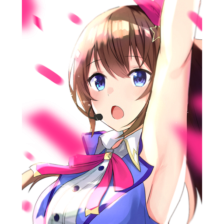

actual tags:
['1girl', 'brown_hair', 'large_breasts', 'close-up', 'eyebrows_visible_through_hair', 'bow', 'headset', 'hair_bow', 'petals', 'bangs', 'virtual_youtuber', 'breasts', 'solo', 'blue_eyes', 'pink_bow', 'armpits', 'open_mouth']


predicted tags with probability above 50%:


,proba
tag,
1girl,85.3%
solo,75.3%
long_hair,50.0%


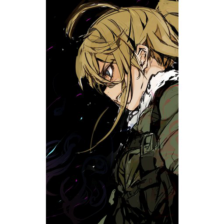

actual tags:
['1girl', 'blonde_hair', 'upper_body', 'jacket', 'sketch', 'messy_hair', 'from_side', 'parted_lips', 'profile', 'fur_trim', 'vest', 'ahoge', 'solo', 'blue_eyes']


predicted tags with probability above 50%:


,proba
tag,
solo,91.1%
1girl,75.9%
blonde_hair,64.0%
red_eyes,54.9%


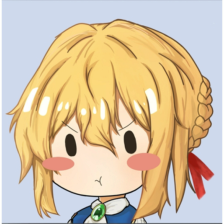

actual tags:
['1girl', 'blonde_hair', 'blush_stickers', 'brooch', 'jewelry', 'braid', 'ribbon', 'red_ribbon', 'chibi']


predicted tags with probability above 50%:


,proba
tag,
blonde_hair,78.6%
1girl,73.7%
solo,67.8%
blush,54.9%


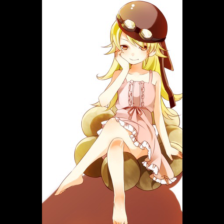

actual tags:
['1girl', 'blonde_hair', 'sitting', 'helmet', 'goggles', 'fang', 'hand_on_own_face', 'barefoot', 'dress', 'yellow_eyes', 'red_eyes', 'long_hair', 'solo', 'crossed_legs', 'food']


predicted tags with probability above 50%:


,proba
tag,
1girl,99.4%
solo,99.1%
long_hair,60.6%
dress,52.6%
breasts,50.1%


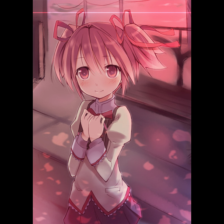

actual tags:
['1girl', 'skirt', 'gift', 'pink_eyes', 'pleated_skirt', 'short_twintails', 'hair_ribbon', 'twintails', 'school_uniform', 'ribbon', 'pink_hair', 'blush', 'smile', 'looking_at_viewer', 'solo']


predicted tags with probability above 50%:


,proba
tag,
1girl,99.2%
solo,97.5%
short_hair,60.7%


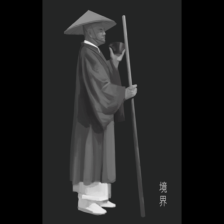

actual tags:
['1boy', 'bowl', 'solo', 'greyscale', 'monochrome', 'hat', 'japanese_clothes', 'staff', 'male_focus']


predicted tags with probability above 50%:


,proba
tag,
solo,82.4%
1boy,62.8%


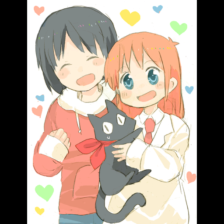

actual tags:
['sketch', 'scarf', 'smile', '2girls', 'cat', 'black_hair', 'multiple_girls', 'blue_eyes', 'blonde_hair', 'heart']


predicted tags with probability above 50%:


,proba
tag,
1girl,77.4%
long_hair,60.3%
solo,56.3%


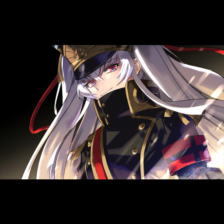

actual tags:
['1girl', 'uniform', 'military_uniform', 'red_eyes', 'hat', 'military', 'white_hair', 'long_hair', 'smile', 'solo']


predicted tags with probability above 50%:


,proba
tag,
solo,82.6%
red_eyes,53.6%


In [13]:
for xb, yb in sample_dl:
    
    show_image(xb.squeeze())
    y_true = proba2lbls(yb.squeeze()).index.to_list()
    y_pred = proba2lbls(model(xb).detach().squeeze())
    
    print(f'actual tags:\n{y_true}\n')
    print('\npredicted tags with probability above 50%:')
    display(y_pred)
    print('\n==============\n')
